In [58]:
import os
import numpy as np
import pandas as pd
from csv import writer
from heapq import merge
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from sklearn.decomposition import PCA
from statsmodels.formula.api import ols
from pyspark.sql.types import IntegerType
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

root
 |-- sa2_name_2016: string (nullable = true)
 |-- sa2_maincode_2016: string (nullable = true)
 |-- erp_2013: integer (nullable = true)
 |-- erp_2014: integer (nullable = true)
 |-- erp_2015: integer (nullable = true)
 |-- erp_2016: integer (nullable = true)
 |-- erp_2017: integer (nullable = true)
 |-- erp_2018: integer (nullable = true)
 |-- erp_2019: integer (nullable = true)
 |-- erp_2020: integer (nullable = true)
 |-- erp_2021: integer (nullable = true)



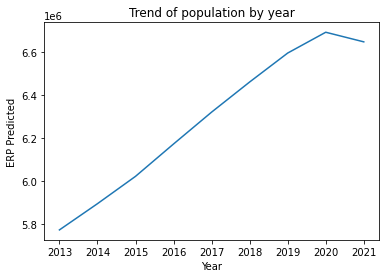

In [59]:
# Extract ERP for each year (Estimated Residential Population)
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

erp_predicted = spark.read.csv("../../generic-real-estate-consulting-project-group-43/data/curated/erp_vic.csv", header=True)

erp_predicted = erp_predicted.withColumn("erp_2013",erp_predicted["erp_2013"].cast(IntegerType()))\
                                .withColumn("erp_2014",erp_predicted["erp_2014"].cast(IntegerType()))\
                                .withColumn("erp_2015",erp_predicted["erp_2015"].cast(IntegerType()))\
                                .withColumn("erp_2016",erp_predicted["erp_2016"].cast(IntegerType()))\
                                .withColumn("erp_2017",erp_predicted["erp_2017"].cast(IntegerType()))\
                                .withColumn("erp_2018",erp_predicted["erp_2018"].cast(IntegerType()))\
                                .withColumn("erp_2019",erp_predicted["erp_2019"].cast(IntegerType()))\
                                .withColumn("erp_2020",erp_predicted["erp_2020"].cast(IntegerType()))\
                                .withColumn("erp_2021",erp_predicted["erp_2021"].cast(IntegerType()))

erp_predicted.printSchema()

# Graph the erp trend line to decide how to predict erp from 2022 - 2027
erp_agg = erp_predicted.groupby().sum().toPandas()

year = ['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

y_axis = erp_agg.iloc[0]

plt.plot(year,y_axis)
plt.title('Trend of population by year')
plt.xlabel('Year')
plt.ylabel('ERP Predicted')
plt.show()

The ERP (estiamted resident population) in Victoria state increases as year progresses with a linear relatonship. it shows a decline between 2020 to 2021, but according to the data from Australian government (`https://population.gov.au/data-and-forecasts/key-data-releases/national-state-and-territory-population-december-2021`) they stated that the decline happened due to the impact of COVID. Since in this project, we assume that COVID will not stay any longer or will have a huge impact as it did between 2019 to 2021 as most of the population is vaccinated by now. Therefore, from this, we got an idea of using a linear regression for our population prediction for 2023-2027.

In [60]:
# Define external predictors
external_preds = ['sa2_2021', 'min_distance_to_cbd','min_distance_to_park', 'min_distance_to_prim', 'min_distance_to_second'\
    , 'min_distance_to_train', 'min_distance_to_hosp', 'min_distance_to_poli', 'min_distance_to_shop', 'gdp', 'saving_rate', 'income_per_person',\
        'crime_cases', 'population_density']

# Define internal predictors
internal_preds = ['residence_type', 'nbed', 'nbath', 'ncar']

# OLS regression function for Data analysis
def ols_regression(merged_df):
    # OLS Regression
    # External ----------------------------------------------------------------------------------------------------
    external_model = ols(formula = 'weekly_rent ~ C(sa2_2021) + min_distance_to_cbd + \
        min_distance_to_park + min_distance_to_prim + min_distance_to_second + min_distance_to_train +\
        min_distance_to_hosp + min_distance_to_poli + min_distance_to_shop + gdp + saving_rate + income_per_person +\
        crime_cases + population_density', data = merged_df).fit()

    # Summary of external factors
    ex_summary = external_model.summary()

    # Anova table of external factors
    ex_anova_table = sm.stats.anova_lm(external_model, typ=2)

    # Extract p-values for the predictors
    ex_pvals = external_model.pvalues[:]

    # Internal ----------------------------------------------------------------------------------------------------
    internal_model = ols(formula = 'weekly_rent ~ C(residence_type) + nbed + nbath + ncar', data = merged_df).fit()

    # Summary of internal factors
    in_summary = internal_model.summary()

    # Anova table of internal factors
    in_anova_table = sm.stats.anova_lm(internal_model, typ=2)

    # Extract p-values for the predictors
    in_pvals = internal_model.pvalues[:]

    return ex_pvals, in_pvals

# csv file function
def put_signigicants_csv(external_preds, ex_pvalues, internal_preds, in_pvalues, new_csv):
    df_ex = len(ex_pvalues) - len(external_preds)

    # Significant predictors for SA2 first
    sign_ex_predictors = [external_preds[0]  for pre in range(df_ex) if ex_pvalues[pre] < 0.05]
    # Significant predictors for rest of the features
    for pre in range(len(external_preds)):
        if ex_pvalues[pre+df_ex] < 0.05:
            sign_ex_predictors.append(external_preds[(pre)])

    sign_in_predictors = [internal_preds[(pre-1)] for pre in range(1, len(in_pvalues)) if in_pvalues[pre] < 0.05]
    
    external_df = pd.DataFrame({'Significant External predictors': sign_ex_predictors})
    internal_df = pd.DataFrame({'Significant Internal predictors': sign_in_predictors})
    new = pd.concat([external_df, internal_df], axis=1) 

    print(new_csv)
    new.to_csv(new_csv)

In [61]:
# Make a new folder for significant variable csv files
# Directory
directory = "significant"
  
# Parent Directory path
parent_dir = "../data/curated/"

# Path
path = os.path.join(parent_dir, directory)

# Create the directory
os.mkdir(path)

In [65]:
# Testing: Looking into 2013 data only with PCA 
# Scrutinize the data with PCA: Test the attribute relevance
merged_df = spark.read.csv("../data/curated/merged_dataset/2013_merged_data.csv", header=True)

for c in merged_df.columns:
    if (c not in  ['address', 'residence_type']):
        merged_df = merged_df.withColumn(c,merged_df[c].cast(IntegerType())) 

merged_df = merged_df.toPandas()

merged_df['residence_type'] = merged_df['residence_type'].astype('category')
merged_df['residence_type'] = merged_df['residence_type'].cat.codes

# For the missing values of distances between a rental property and each feature of interest, 
# fill them up with a huge value because they are missing as rental properites are far away 
# where API OPen Route cannot measure distances.
merged_df.iloc[:, 13:21] = merged_df.iloc[:, 13:21].replace(np.nan, 99999)

merged_df = merged_df.dropna()

X = merged_df.drop(['address', 'weekly_rent', 'latitude', 'longitude', 'postcode', 'sa2_2016'], axis=1)
y = merged_df['weekly_rent']

By looking at the graph generated by applying PCA on the data 2013, the explained variance value is already reached at its maximum value 100% with only the first 15 features. This means the last 4 features which are saving rate, income_per_person, population_density, and crime_cases are not significant predictors. Since our team predicted that either population density or income per person by SA2 regions will be significant variavles, we decided to proceed other data analysis methods to be sure. 

In [63]:
# Scrutinize the data with PCA: Test the attribute relevance for only 2013 (For testing)
merged_df.rename(columns = {'gdp(USD Millioins)':'gdp', 'saving_rate(% of GDP)':'saving_rate'}, inplace = True)

ex_pvalues, in_pvalues = ols_regression(merged_df)

/home/hyunjinp/.local/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 465, but rank is 463
  warnings.warn('covariance of constraints does not have full '


We decided the data into internal and external factors to predict weekly rental prices of rental properties because we wanted to scrutinize the data with more depth. </br> </br>
### Internal factors are:</br>
1. The residence type of a rental property </br>
2. The number of bedrooms of a rental property </br>
3. The number of bathrooms of a rental property</br>
4. The number of car parking spaces of a rental property</br>
</br>

### External factors are: </br>
1. SA2_2021 </br>
2. Minimum distance from a rental property to cbd  </br>
3. Minimum distance from a rental property to a closest park / primary&secondary schools / train station / hospital / police office / shopping mall </br> 
4. Yearly GDP of each SA2 region  </br>
5. Yearly Saving rate of each SA2 region </br>
6. Yearly Income per person by each SA2 region</br>
7. Yearly Crime cases by each SA2 region</br>
8. Yearly Population density by each SA2 region</br>
</br>

**Please note that the following results mentioned in this pargraph is only about 2013** for testing if using anova table and summary table of ols regression can perform data analysis; which features are significant to predict weekly rental price. 
</br>

It shows that all the internal factors are significant and some of the external features are significant from anova table. It is better to read data from anova table's f tests because they show the significance of the feature in terms of the whole model. For example, a t-test value from summary table of a 'income per person' means if this 'income per person' feature itself only is significant or not in this model while ignoring all the impacts of the other features. But f-test value of 'income per person' shows what happens if this attribute disappears from the model with the other features included and tells if having this value or not makes any significant differences to the model prediction. The highlighted finding from this anova table result shows that the income per person feature actually plays a significant role to predict weekly rental price of a property for 2013 dataset.


In [64]:
# Implement for every file to see annual trend
parent_dir = "../data/curated/merged_dataset"

for filename in os.listdir(parent_dir):
    print(filename, "----------------------------------------------------------------------------------------------------------------")
    merged_df_yr = spark.read.csv(parent_dir + "/" + filename, header=True)
    for c in merged_df_yr.columns:
        if (c not in  ['address', 'residence_type']):
            merged_df_yr = merged_df_yr.withColumn(c,merged_df_yr[c].cast(IntegerType())) 

    merged_df_yr = merged_df_yr.toPandas()

    merged_df_yr['residence_type'] = merged_df_yr['residence_type'].astype('category')
    merged_df_yr['residence_type'] = merged_df_yr['residence_type'].cat.codes

    merged_df_yr.iloc[:, 13:21] = merged_df_yr.iloc[:, 13:21].replace(np.nan, 99999)

    merged_df_yr = merged_df_yr.dropna()

    merged_df_yr.rename(columns = {'gdp(USD Millioins)':'gdp', 'saving_rate(% of GDP)':'saving_rate'}, inplace = True)

    # Implement ols regression to analyze the data
    ex_pvalues, in_pvalues = ols_regression(merged_df_yr)
    
    new_csv_name = "../data/curated/significant/" + filename

    put_signigicants_csv(external_preds, ex_pvalues, internal_preds, in_pvalues, new_csv_name)

2013_merged_data.csv ----------------------------------------------------------------------------------------------------------------


/home/hyunjinp/.local/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 465, but rank is 463
  warnings.warn('covariance of constraints does not have full '


../data/curated/significant/2013_merged_data.csv
2021_merged_data.csv ----------------------------------------------------------------------------------------------------------------


/home/hyunjinp/.local/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 498, but rank is 497
  warnings.warn('covariance of constraints does not have full '


../data/curated/significant/2021_merged_data.csv
2020_merged_data.csv ----------------------------------------------------------------------------------------------------------------


/home/hyunjinp/.local/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 492, but rank is 491
  warnings.warn('covariance of constraints does not have full '


../data/curated/significant/2020_merged_data.csv
2022_merged_data.csv ----------------------------------------------------------------------------------------------------------------


/home/hyunjinp/.local/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 498, but rank is 497
  warnings.warn('covariance of constraints does not have full '


../data/curated/significant/2022_merged_data.csv
2018_merged_data.csv ----------------------------------------------------------------------------------------------------------------


/home/hyunjinp/.local/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 489, but rank is 488
  warnings.warn('covariance of constraints does not have full '


../data/curated/significant/2018_merged_data.csv
2014_merged_data.csv ----------------------------------------------------------------------------------------------------------------


/home/hyunjinp/.local/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 482, but rank is 481
  warnings.warn('covariance of constraints does not have full '


../data/curated/significant/2014_merged_data.csv
2017_merged_data.csv ----------------------------------------------------------------------------------------------------------------


/home/hyunjinp/.local/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 489, but rank is 488
  warnings.warn('covariance of constraints does not have full '


../data/curated/significant/2017_merged_data.csv
2015_merged_data.csv ----------------------------------------------------------------------------------------------------------------


/home/hyunjinp/.local/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 482, but rank is 480
  warnings.warn('covariance of constraints does not have full '


../data/curated/significant/2015_merged_data.csv
2019_merged_data.csv ----------------------------------------------------------------------------------------------------------------


/home/hyunjinp/.local/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 490, but rank is 489
  warnings.warn('covariance of constraints does not have full '


../data/curated/significant/2019_merged_data.csv
2016_merged_data.csv ----------------------------------------------------------------------------------------------------------------


/home/hyunjinp/.local/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 489, but rank is 488
  warnings.warn('covariance of constraints does not have full '


../data/curated/significant/2016_merged_data.csv


All year data (2013-2022) have been run and based on the f-test values from the anova models of each year, the significant features were extracted and listed in csv files for better readability.</br>
As going through the csv files, our team found out that for internal factors, except the number of car parking spaces, all the features are significant. However, the external features tend to change for each year for some reasons so we decided to scrutinize more with AIC forward selection for a better analysis.